In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
from scipy.stats import norm, normaltest

%matplotlib inline

from tqdm.auto import tqdm

# Задание 1
Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).
Функция должна быть написана на python. В ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данных.

In [2]:
reg_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-d-merinov-24/shared/problem1-reg_data.csv',
                       sep=';')
auth_data = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-d-merinov-24/shared/problem1-auth_data.csv',
                        sep=';')

In [3]:
def get_df(registration_df, date_column_reg, authorization_df, date_column_auth, user_id):
    '''
    get_df (registration_df, date_column_reg, authorization_df, date_column_auth, user_id)
    возвращает датафрейм с датой регистрации и авторизации по каждому id пользователя
    
    Parameters: 

            registration_df - датафрейм с датой регистрации пользователей
            authorization_df - датафрейм с датой авторизации пользователей
            date_column_reg - str, названия столбца с датой регистрации пользователя
            date_column_auth - str, названия столбца с датой авторизации пользователя
            user_id - str, названия столбца с id пользователя
    '''
    
    registration_df['date'] = registration_df[date_column_reg].apply(lambda d: datetime.fromtimestamp(d))
    authorization_df['date'] = authorization_df[date_column_auth].apply(lambda d: datetime.fromtimestamp(d))
    
    all_data = registration_df.merge(authorization_df, how='left', on=f'{user_id}')
    all_data = all_data.rename(columns={'date_x': 'reg_date', 'date_y': 'auth_date'})
    
    return all_data

In [4]:
def get_retention(all_data, lineplot=False, distance=None):
   
    '''
    get_retention(all_data) возвращает сводную таблицу с уровнем retention 

    Parameters: 

            all_data - датафрейм с данными по регистрации и авторизации пользователей
            lineplot - boolean, True - возвращает график
            distance - int, кол-во дней для подсчета retention
    '''
    
    all_data['distance'] = (all_data.auth_date - all_data.reg_date).dt.days
    ret = all_data.groupby('distance').agg({'uid': 'nunique'})
    ret['retention'] = ret.uid.div(ret.uid[0])
    
    if lineplot:
        if distance is not None:
            return sns.lineplot(data=ret.query(f'distance < {distance + 1}'), x='distance', y='retention')
        return sns.lineplot(data=ret, x='distance', y='retention')
    else:
        return ret

In [5]:
new = get_df(reg_data, 'reg_ts', auth_data, 'auth_ts', 'uid')

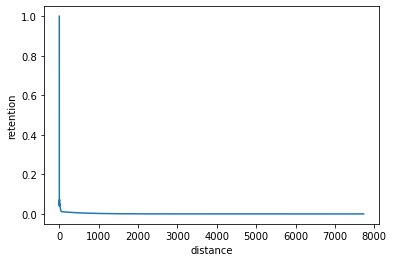

In [6]:
reten = get_retention(new, lineplot=True)

In [7]:
def get_retention_cohort(all_data, cohort='M', distance=30, percent=True):
    
    '''
    get_retention_cohort(all_data, cohort='M', distance=None) возвращает сводную таблицу с уровнем retention 

    Parameters: 

            all_data - датафрейм с данными по регистрации и авторизации пользователей
            cohort - str, делит пользователей на когорты 
                M -месяц
                Y - год
                W - неделя
                d - день
            distance - int, кол-во дней для подсчета retention
            percent - bool, 
                True  - возвращает retention процентах
                False - показывает абсолютное значение
    '''
    
    # создаем когорты поьзователей
    all_data['cohort'] = all_data.reg_date.dt.to_period(f'{cohort}')
    
    #  расчитываем дистанцию 
    all_data['distance'] = (all_data.auth_date - all_data.reg_date).dt.days
    
    # создаем сводну. таблицу для отображения результатов
    cohort_pivot_table = pd.pivot_table(all_data.query(f'distance <= {distance}'), 
                                        index='cohort', 
                                        columns='distance', 
                                        values='uid', 
                                        aggfunc=pd.Series.nunique)
    if percent:
        cohort_pivot_table_div = cohort_pivot_table.div(cohort_pivot_table[0], axis=0).drop(0, axis=1)    
        return cohort_pivot_table_div
    else:
        return cohort_pivot_table

In [8]:
start_date = '2020-06-01'
end_date = '2020-06-30'
new1 = new.query('reg_date >= @start_date and reg_date <= @end_date')

In [9]:
get_retention_cohort(new1, cohort='M')

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


distance,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
cohort,,,,,,,,,,,,,,,,,,,,,
2020-06,0.03798,0.043519,0.049899,0.055586,0.064166,0.072375,0.043841,0.05158,0.052075,0.051877,...,0.037387,0.037412,0.035829,0.033826,0.031848,0.032887,0.032367,0.030167,0.029178,0.027694


In [10]:
get_retention(new1)

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,uid,retention
distance,,
0,40442,1.000000
1,1536,0.037980
2,1760,0.043519
3,2018,0.049899
4,2248,0.055586
...,...,...
110,72,0.001780
111,62,0.001533
112,34,0.000841


# Задание 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [11]:
df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-d-merinov-24/shared/problem2.csv', sep=';')
df

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


Для начала проведем анализ описательной статистики по нашим данным.
Мы можем заметить, что медианное значение равно 0 - это значит, что более 50% всех пользователей не совершали покупки.

In [12]:
# описательная статистика по полю revenue
df.groupby('testgroup').agg({'user_id': 'count', 'revenue': ['sum', 'mean', 'median']})

user_id  revenue                  
            count      sum       mean median
testgroup                                   
a          202103  5136189  25.413720      0
b          202667  5421603  26.751287      0

Посмотрим более подробно на описательную статистику по всеиму df и отдельно по каждой группе

In [13]:
df.revenue.describe()

count    404770.000000
mean         26.083435
std         681.652928
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       37433.000000
Name: revenue, dtype: float64

In [14]:
df.query('testgroup == "a"').revenue.describe()

count    202103.000000
mean         25.413720
std         920.768137
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       37433.000000
Name: revenue, dtype: float64

In [15]:
df.query('testgroup == "b"').revenue.describe()

count    202667.000000
mean         26.751287
std         287.324162
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        4000.000000
Name: revenue, dtype: float64

In [16]:
df.query('testgroup == "a" and revenue > 1000').revenue

416       37324
4428      37304
5777      37315
8065      37307
8743      37334
          ...  
360696    37347
378668    37297
389341    37298
394580    37302
399294    37321
Name: revenue, Length: 123, dtype: int64

In [17]:
df.query('testgroup == "a" and revenue < 1000').revenue.max()

400

Наблюдается интересная ситуация: в контрольной группе максимальное значение "revenue" выше, чем в тестовой.

Можно предположить, что это связано с тем, что существует группа пользователей в нашей игре, которая тратит довольно большое кол-во денег на внутриигровые покупки (учитывая, что суммы примерно одинаковые, можно сказать, что в игре есть определенный лимит на внутриигровые покупки, и данная группа пользователей купила почти все внутриигровые предеметы)

Однако очень странно, что ни один из них не попал в тестовую группу. Возможно 2 причины:
1. Проблема в системе сплитования, в связи с чем данная группа пользователей не попали в тестовую группу
2. Возможно данные пользователи купили уже предметы, что были в акции и поэтому такие покупки не наблюдаются в тестовой группе.

Так как мы не знаем какого характера была акция (какие предметы (новые или старые), цены, аудиторию (для новых пользователей, для старых), требования к покупке акционного набора (нужен ли какой-то определенный уровень) и т.п.), будет логично предположить, что проблема именно в системе сплитования.


In [18]:
# выделим отдельно df с тестовой и контрольной выборками
df_test = df.query('testgroup == "b"')
df_control = df.query('testgroup == "a"')

Мы уже знаем, что более 75% пользователей не совершали покупки в нашей игре, но для анализа посмотрим на их распределение, а также проведем тест на нормальность

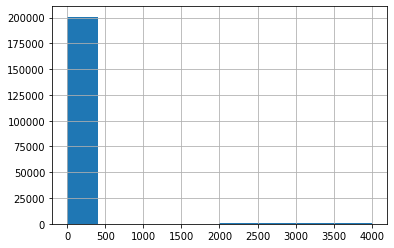

In [19]:
df_test.revenue.hist()

In [20]:
# проведем тест на нормальность распределения тестовой выборки
normaltest(df_test.revenue)

NormaltestResult(statistic=326622.39540856465, pvalue=0.0)

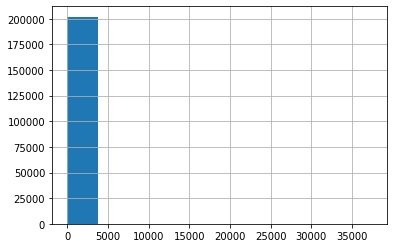

In [21]:
df_control.revenue.hist()

In [22]:
# проведем тест на нормальность распределения контрольной выборки
normaltest(df_control.revenue)

NormaltestResult(statistic=585152.7312728433, pvalue=0.0)

Как видно на графике, так видно и теста на нормальность распределения, что обе выборки в данном случае распределены ненормально, поэтому для дальнейшего анализа будем использовать Bootsrtap

#### Применим бутстрап (с np.mean) для анализа ARPU

H0: значимых различий в тестовой и контрольных выборках нет

H1: есть значимые различия в тестовой и контрольных выборках

In [23]:
def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it = 1000,  # количество бутстрэп-подвыборок
    statistic = np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):  #извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace=True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1 - samples_2))  # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins=50)
    
    plt.style.use('ggplot')
    plt.vlines(ci, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

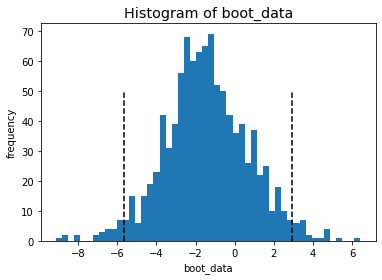

In [24]:
booted_data_test_arpu = get_bootstrap(df_control.revenue, df_test.revenue, statistic=np.mean)

In [25]:
booted_data_test_arpu['ci']

,0
0.025,-5.654440
0.975,2.918129


In [26]:
booted_data_test_arpu["p_value"]

0.5026381083726472

Согласно проведенному тесту видим, что значение p_value > 0.05 и доверительный интервал имеет границы [-5.654440; 2.918129], в который попадает 0. 
Таким образом, мы не можем отклонить нулевую гипотезу на заданном уровне значимости.

#### Применим бутстрап (с np.mean) для анализа конверсии

H0: значимых различий в тестовой и контрольных выборках нет

H1: есть значимые различия в тестовой и контрольных выборках

In [27]:
# для начала создадим столбец с конверсией для тестовой и контрольной выборки
df_test['cr'] = df_test.revenue.apply(lambda x: 1 if x > 0 else 0 )
df_control['cr'] = df_control.revenue.apply(lambda x: 1 if x > 0 else 0 )

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [28]:
df_test['cr'].value_counts()

0    200862
1      1805
Name: cr, dtype: int64

In [29]:
df_control['cr'].value_counts()

0    200175
1      1928
Name: cr, dtype: int64

In [33]:
cr_df = pd.DataFrame([df_test['cr'].mean()*100, df_control['cr'].mean()*100]).T.rename(columns={0:'CR_test', 1:'CR_control'})
cr_df

,CR_test,CR_control
0,0.890624,0.953969


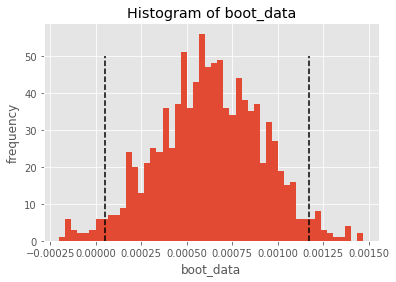

In [34]:
booted_data_test_cr = get_bootstrap(df_control.cr, df_test.cr, statistic=np.mean)

In [35]:
booted_data_test_cr['ci']

,0
0.025,0.000049
0.975,0.001169


In [36]:
booted_data_test_cr["p_value"]

0.028678980537184175

Согласно проведенному тесту видим, что значение p_value < 0.05 и доверительный интервал имеет границы [0.000049; 0.001169], в который не попадает 0. 
Таким образом, мы можем отклонить нулевую гипотезу на заданном уровне значимости.

#### Применим бутстрап (с np.mean) для анализа ARPPU

H0: значимых различий в тестовой и контрольных выборках нет

H1: есть значимые различия в тестовой и контрольных выборках

In [37]:
# расчет краткой описательнйо статистике для платящих пользователей
df.query('0 < revenue').groupby('testgroup').agg({'user_id': 'count', 'revenue': ['sum', 'mean', 'median']})

user_id  revenue                    
            count      sum         mean median
testgroup                                     
a            1928  5136189  2663.998444    311
b            1805  5421603  3003.658172   3022

In [38]:
# создаем новый дф с платящими пользователями по тестовой группе
df_test_pay = df.query('testgroup == "b" and revenue > 0')
# создаем новый дф с платящими пользователями по контрольной группе
df_control_pay = df.query('testgroup == "a" and revenue > 0')

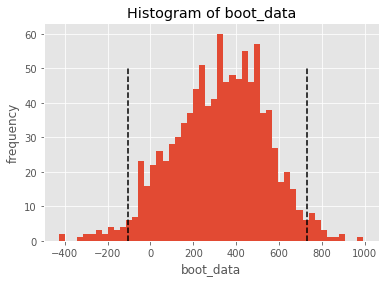

In [39]:
booted_data_test_arppu = get_bootstrap(df_test_pay.revenue, df_control_pay.revenue, statistic=np.mean)

In [40]:
booted_data_test_arppu['ci']

,0
0.025,-105.609453
0.975,731.249883


In [41]:
booted_data_test_arppu["p_value"]

0.13386948114227826

Согласно проведенному тесту видим, что значение p_value > 0.05 и доверительный интервал имеет границы [-105.609453; 731.249883], в который попадает 0. 
Таким образом, мы не можем отклонить нулевую гипотезу на заданном уровне значимости.

Таким образом, было проведено небольшое исследование результатов различных акционных предлоежения в компьютерной игре.
Для анализа результатов было проведено 3 A/B теста на 3 метриках: ARPU, ARPPU, Convertion rate.

1. Результаты A/B теста ARPU, показали, что значимых различий между тестовой и контрольной выборками нет.
2. Результаты A/B теста ARPPU, показали, что значимых различий между тестовой и контрольной выборками тоже нет.
3. Результаты A/B теста CR, наоборот показали, что значимые различия между тестовой и контрольной выборками есть на уровне значимости 0.05.

Так, можно сделать вывод, что новое акционное предложение статистически значимо не повлияло на показатели ARPU и ARPPU.
Однако можно утверждать, что статистически значимо снизился уровень конверсии среди пользователей тестовой группы по сравнении с контрольной.

Однако стоит обратить внимание, что в контрольной выборке есть пользователи, чьи траты очень высокие (более 37 000), и данных пользователей нет в тестовой выборке, что связано скорее всего с системой сплитования.

Поэтому для того, чтобы получить более точные результаты рекомендуется перепроверить систему сплитования. 
 - Если в ней есть ошибки, то сделать новое сплитование пользователей - проверить его A/A тестом, и после этого провести новый A/B тест. 
 - Если в системе сплитования нет ошибок, то тогда можно сделать вывод, что данное акционное предложение статистически значимо не повлияло на ARPU и ARPPU, но при этом снизило показатель CR.



# Задание 3

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

#### Стандартные метрики

- MAU
- DAU
- WAU
- Retention (можно посмотреть как отдельно для игрового события, так и взять время отсчета до: сколько пользователей вернулось в игру)


#### Кастомные метрики
1. кол-во пройденных уровней: 
    - среднее значение пройденных уровней 1 игроком
    - среднее значение пройденных уровней
2. кол-во дней проведенных в течение события:
    - среднее значение
    - среднее время 1 игрока в игре

** если в игре есть возможность за деньги скипнуть уровень**
3. кол-во купленных пропусков уровней 
    - среднее значение купленных прокусков
    - среднее кол-во купленных прокусков 1 игроком    